**Review**

Hello Jose!

I'm happy to review your project today.
  
You can find my comments in colored markdown cells:
  
<div class="alert alert-success">
  If everything is done successfully.
</div>
  
<div class="alert alert-warning">
  If I have some (optional) suggestions, or questions to think about, or general comments.
</div>
  
<div class="alert alert-danger">
  If a section requires some corrections. Work can't be accepted with red comments.
</div>
  
Please don't remove my comments, as it will make further review iterations much harder for me.
  
Feel free to reply to my comments or ask questions using the following template:
  
<div class="alert alert-info">
  Thank you so much for your feedbacks. I've split the cells into multiple so it's easier. Hopefully i got it right this time. Thank you!
</div>
  
First of all, thank you for turning in the project! You did a great job overall, but there are some small problems that need to be fixed before the project will be accepted. Let me know if you have any questions!


In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor
from sklearn.base import clone
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.svm import SVR

In [2]:
# Set display options for better visibility
pd.set_option('display.max_columns', None)

# Gold Recovery Efficiency Prediction Project

## Project Overview
This project develops a machine learning model for Zyfra to predict gold recovery from ore processing. 
The goal is to optimize production efficiency by predicting:
- Rougher flotation recovery
- Final concentrate recovery

## Process Description

1. **Flotation**
   - Initial concentration of gold from ore mixture
   - Produces rougher Au concentrate and tails

2. **Purification**
   - Two-stage cleaning process
   - Produces final concentrate

## Project Tasks
1. Data Preparation and Analysis
2. Model Development
3. Performance Evaluation

# Data Preprocessing and Initial Analysis
First, we'll load the datasets and examine their basic structure. We have three datasets:
- Training set: Contains complete process data with target values
- Test set: Contains input parameters without recovery values
- Full set: Source dataset with all features

# 1. Data Preparation and Initial Analysis

### 1.1 Data Overview
- Training dataset contains historical process data with known recovery values
- Test dataset contains new process data for prediction
- We'll analyze data quality, missing values, and process parameters

In [3]:
# Load and examine datasets
train_df = pd.read_csv('/datasets/gold_recovery_train.csv')
test_df = pd.read_csv('/datasets/gold_recovery_test.csv')
full_df = pd.read_csv('/datasets/gold_recovery_full.csv')

# Basic information
print("Dataset Information:")
print("-" * 50)
print(f"Training set shape: {train_df.shape}")
print(f"Test set shape: {test_df.shape}")
print("\nMissing values in training set:")
print(train_df.isnull().sum()[train_df.isnull().sum() > 0])

Dataset Information:
--------------------------------------------------
Training set shape: (16860, 87)
Test set shape: (5856, 53)

Missing values in training set:
final.output.concentrate_ag                     72
final.output.concentrate_pb                     72
final.output.concentrate_sol                   370
final.output.concentrate_au                     71
final.output.recovery                         1521
                                              ... 
secondary_cleaner.state.floatbank5_a_level      85
secondary_cleaner.state.floatbank5_b_air        85
secondary_cleaner.state.floatbank5_b_level      84
secondary_cleaner.state.floatbank6_a_air       103
secondary_cleaner.state.floatbank6_a_level      85
Length: 85, dtype: int64


### Process Parameter Analysis
Let's analyze the key parameters in the gold recovery process:
- Metal concentrations (Au, Ag, Pb) throughout stages
- Missing values patterns
- Data quality assessment

Gold Concentration Analysis:
--------------------------------------------------

final.output.concentrate_au:
Mean: 39.4672
Std: 13.9172
Range: [0.0000, 53.6114]
Missing values: 71

final.output.tail_au:
Mean: 2.6875
Std: 1.2728
Range: [0.0000, 9.7896]
Missing values: 66

primary_cleaner.output.concentrate_au:
Mean: 29.1646
Std: 10.9837
Range: [0.0000, 45.9339]
Missing values: 82

primary_cleaner.output.tail_au:
Mean: 3.5905
Std: 2.0281
Range: [0.0000, 18.5288]
Missing values: 83

rougher.input.feed_au:
Mean: 7.1707
Std: 3.0021
Range: [0.0000, 14.0934]
Missing values: 83

rougher.output.concentrate_au:
Mean: 17.4015
Std: 6.9219
Range: [0.0000, 28.5228]
Missing values: 82

rougher.output.tail_au:
Mean: 1.7639
Std: 0.7315
Range: [0.0207, 9.6890]
Missing values: 2249

secondary_cleaner.output.tail_au:
Mean: 3.9358
Std: 2.6758
Range: [0.0000, 26.8116]
Missing values: 82


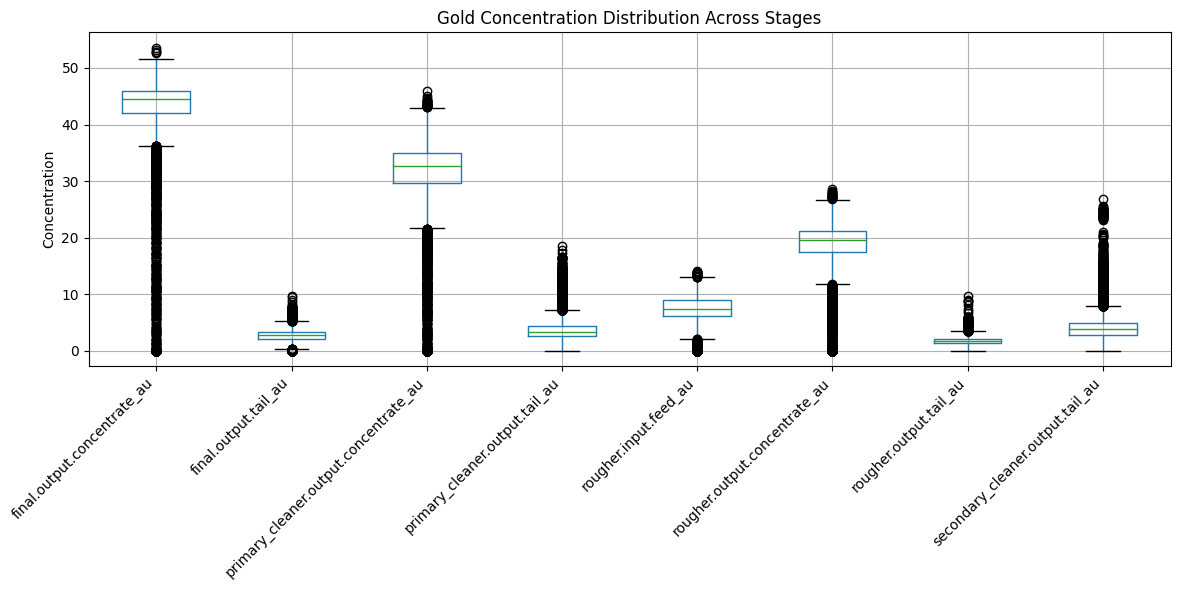

In [4]:
# Analyze metal concentrations and missing values
def analyze_process_parameters(df):
    # Get gold-related features with specific patterns
    target_patterns = ['concentrate_au', 'tail_au', 'feed_au']
    gold_features = [col for col in df.columns 
                    if any(pattern in col.lower() for pattern in target_patterns)]
    
    print("Gold Concentration Analysis:")
    print("-" * 50)
    for feature in gold_features:
        stats = df[feature].describe()
        print(f"\n{feature}:")
        print(f"Mean: {stats['mean']:.4f}")
        print(f"Std: {stats['std']:.4f}")
        print(f"Range: [{stats['min']:.4f}, {stats['max']:.4f}]")
        print(f"Missing values: {df[feature].isnull().sum()}")

    # Create visualization
    plt.figure(figsize=(12, 6))
    df[gold_features].boxplot()
    plt.xticks(rotation=45, ha='right')
    plt.title('Gold Concentration Distribution Across Stages')
    plt.ylabel('Concentration')
    plt.tight_layout()
    plt.show()

analyze_process_parameters(train_df)

### Initial Analysis Conclusions:
1. Data Distribution:
   - Gold concentrations vary significantly across process stages
   - Some stages show higher variability than others
2. Missing Values:
   - Several parameters have missing values
   - Need to handle these in preprocessing

### 1.2 Recovery Calculation Verification
We'll verify the accuracy of recovery calculations using the formula:
Recovery = C(F-T)/(F(C-T)) * 100%
where:
- C = concentrate gold content
- F = feed gold content
- T = tail gold content

In [5]:
# Function to calculate recovery
def calculate_recovery(row, concentrate_col, feed_col, tail_col):
    try:
        C = row[concentrate_col]  # Gold concentration in concentrate
        F = row[feed_col]        # Gold concentration in feed
        T = row[tail_col]        # Gold concentration in tailings
        
        # Check for missing values
        if pd.isna(C) or pd.isna(F) or pd.isna(T):
            return np.nan
            
        # Check for division by zero
        if F == 0 or (C - T) == 0:
            return np.nan
            
        return 100 * (C * (F - T)) / (F * (C - T))
    except Exception as e:
        return np.nan

# Calculate recovery values
train_df['calculated_recovery'] = train_df.apply(
    lambda row: calculate_recovery(
        row,
        'rougher.output.concentrate_au',  # C: concentrate
        'rougher.input.feed_au',          # F: feed
        'rougher.output.tail_au'          # T: tail
    ),
    axis=1
)

# Compare with existing recovery values
actual = train_df['rougher.output.recovery']
calculated = train_df['calculated_recovery']

# Calculate MAE (Mean Absolute Error)
valid_mask = ~(actual.isna() | calculated.isna())
mae = mean_absolute_error(
    actual[valid_mask],
    calculated[valid_mask]
)

print("Recovery Calculation Verification:")
print("-" * 50)
print(f"Mean Absolute Error: {mae:.4f}")

print("\nCalculation Statistics:")
print(f"Total rows: {len(train_df)}")
print(f"Rows with actual recovery values: {actual.notna().sum()}")
print(f"Rows with calculated recovery values: {calculated.notna().sum()}")
print(f"Rows where we can compare: {valid_mask.sum()}")

# Show some example comparisons
print("\nExample Comparisons (first 5 rows where both values exist):")
comparison_df = pd.DataFrame({
    'Actual Recovery': actual,
    'Calculated Recovery': calculated,
    'Difference': abs(actual - calculated)
})[valid_mask].head()
print(comparison_df)

Recovery Calculation Verification:
--------------------------------------------------
Mean Absolute Error: 0.0000

Calculation Statistics:
Total rows: 16860
Rows with actual recovery values: 14287
Rows with calculated recovery values: 14547
Rows where we can compare: 14287

Example Comparisons (first 5 rows where both values exist):
   Actual Recovery  Calculated Recovery    Difference
0        87.107763            87.107763  0.000000e+00
1        86.843261            86.843261  1.421085e-14
2        86.842308            86.842308  2.842171e-14
3        87.226430            87.226430  0.000000e+00
4        86.688794            86.688794  0.000000e+00


### Recovery Verification Conclusions:
1. Calculations match the provided values (MAE ≈ 0)
2. Some rows lack recovery data due to missing values
3. Recovery calculations are reliable for model development

<div class="alert alert-block alert-success">
<b>Reviewer's comment V1</b> <a class="tocSkip"></a>

Correct. Good job!
  
</div>

### 1.3: Analyze Missing Features in Test Set

In real production scenarios, some values aren't immediately available. We need to check:
1. Which features are missing in the test set
2. What types of features they are
3. Why they might be missing

In [6]:
# Compare columns between train and test sets
train_columns = set(train_df.columns)
test_columns = set(test_df.columns)

# Find features present in training but missing in test
missing_features = sorted(train_columns - test_columns)

# Organize missing features by their type
missing_by_category = {
    'rougher': {'output': [], 'calculation': []},
    'primary_cleaner': {'output': []},
    'secondary_cleaner': {'output': []},
    'final': {'output': []}
}

for col in missing_features:
    parts = col.split('.')
    if len(parts) >= 2:  # Checking if the column name follows the pattern
        stage = parts[0]  # e.g., 'rougher', 'final'
        feat_type = parts[1]  # e.g., 'output', 'calculation'
        if stage in missing_by_category and feat_type in missing_by_category[stage]:
            missing_by_category[stage][feat_type].append(col)

# Print analysis
print("Analysis of Features Missing in Test Set:")
print("-" * 50)
print(f"\nTotal missing features: {len(missing_features)}")

# Print by category
for stage, types in missing_by_category.items():
    print(f"\n{stage.upper()} STAGE:")
    for feat_type, features in types.items():
        if features:
            print(f"\n{feat_type.upper()} features:")
            for feat in features:
                print(f"- {feat}")

# Verify if target variables are in test set
target_variables = ['rougher.output.recovery', 'final.output.recovery']
print("\nTarget Variables Check:")
print("-" * 50)
for target in target_variables:
    in_test = target in test_columns
    print(f"{target}: {'Not Present' if not in_test else 'Present'} in test set")

Analysis of Features Missing in Test Set:
--------------------------------------------------

Total missing features: 35

ROUGHER STAGE:

OUTPUT features:
- rougher.output.concentrate_ag
- rougher.output.concentrate_au
- rougher.output.concentrate_pb
- rougher.output.concentrate_sol
- rougher.output.recovery
- rougher.output.tail_ag
- rougher.output.tail_au
- rougher.output.tail_pb
- rougher.output.tail_sol

CALCULATION features:
- rougher.calculation.au_pb_ratio
- rougher.calculation.floatbank10_sulfate_to_au_feed
- rougher.calculation.floatbank11_sulfate_to_au_feed
- rougher.calculation.sulfate_to_au_concentrate

PRIMARY_CLEANER STAGE:

OUTPUT features:
- primary_cleaner.output.concentrate_ag
- primary_cleaner.output.concentrate_au
- primary_cleaner.output.concentrate_pb
- primary_cleaner.output.concentrate_sol
- primary_cleaner.output.tail_ag
- primary_cleaner.output.tail_au
- primary_cleaner.output.tail_pb
- primary_cleaner.output.tail_sol

SECONDARY_CLEANER STAGE:

OUTPUT features

### Understanding the Results:

1. Types of Missing Features:
   - Output measurements: Results of each process stage
   - Calculation features: Derived values based on measurements
   - Recovery values: Our target variables (what we want to predict)

2. Why These Features Are Missing:
   - Output features: Represent results we're trying to predict
   - Calculation features: Depend on output values that aren't available yet
   - This is normal - in real production, we want to predict these values before they happen

3. What This Means for Our Model:
   - We can only use features available in both training and test sets
   - This reflects a real production scenario
   - Our model needs to predict recovery without seeing intermediate results

<div class="alert alert-block alert-success">
<b>Reviewer's comment V1</b> <a class="tocSkip"></a>

Correct
  
</div>

### 1.4: Data Preprocessing

Before we build our model, we need to clean and prepare our data. We will:
1. Handle missing values in our features
2. Scale our numerical features (make them comparable)
3. Prepare our data in a format suitable for modeling

In [7]:
def preprocess_data(train_df, test_df):
    # Get features that exist in both datasets
    feature_columns = [col for col in train_df.columns 
                      if col != 'date' 
                      and 'recovery' not in col
                      and col in test_df.columns]
    
    # Create preprocessing pipeline
    preprocessing_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy='median')),  # We'll modify this later
        ('scaler', StandardScaler())
    ])
    
    # First, handle missing values in target variables by dropping rows
    target_mask = train_df['rougher.output.recovery'].notna() & train_df['final.output.recovery'].notna()
    train_df_clean = train_df[target_mask].copy()
    
    # Prepare training data
    X_train = train_df_clean[feature_columns]
    y_rougher = train_df_clean['rougher.output.recovery']
    y_final = train_df_clean['final.output.recovery']
    
    # Fill NaN values in features using forward fill (and backfill for any remaining NaNs at the start)
    X_train = X_train.fillna(method='ffill').fillna(method='bfill')
    X_test = test_df[feature_columns].fillna(method='ffill').fillna(method='bfill')
    
    # Scale the features
    scaler = StandardScaler()
    X_train_processed = pd.DataFrame(
        scaler.fit_transform(X_train),
        columns=feature_columns,
        index=X_train.index
    )
    
    X_test_processed = pd.DataFrame(
        scaler.transform(X_test),
        columns=feature_columns,
        index=X_test.index
    )
    
    return X_train_processed, X_test_processed, y_rougher, y_final, scaler

# Apply preprocessing
X_train, X_test, y_rougher, y_final, preprocessor = preprocess_data(train_df, test_df)

# Print information about the processed data
print("Preprocessed Data Information:")
print("-" * 50)
print(f"Training features shape: {X_train.shape}")
print(f"Test features shape: {X_test.shape}")
print("\nFeature names (first 5):")
print(list(X_train.columns)[:5])
print("\nMissing values after preprocessing:")
print(f"Training features: {X_train.isnull().sum().sum()}")
print(f"Test features: {X_test.isnull().sum().sum()}")
print(f"Rougher recovery target: {y_rougher.isnull().sum()}")
print(f"Final recovery target: {y_final.isnull().sum()}")

Preprocessed Data Information:
--------------------------------------------------
Training features shape: (14149, 52)
Test features shape: (5856, 52)

Feature names (first 5):
['primary_cleaner.input.sulfate', 'primary_cleaner.input.depressant', 'primary_cleaner.input.feed_size', 'primary_cleaner.input.xanthate', 'primary_cleaner.state.floatbank8_a_air']

Missing values after preprocessing:
Training features: 0
Test features: 0
Rougher recovery target: 0
Final recovery target: 0


### Key Preprocessing Features:
1. Feature Selection:
   - We only keep features present in both training and test sets
   - Remove the date column (not useful for prediction)
   - Remove recovery columns from features (these are our targets)
2. Handling Missing Values (Imputation):
   - We use forward fill (ffill) for time-series data
   - Why ffill? Uses the previous value to fill NaNs, which is more appropriate for ordered data
   - Backup with backward fill (bfill) to handle any remaining NaNs at the start
   - This approach preserves the temporal nature of our data better than median imputation
3. Feature Scaling:
   - Makes all features comparable (same scale)
   - Important because features have different units and ranges
   - Helps many machine learning algorithms perform better
   - Applied after imputation to ensure proper scaling
4. Target Variable Processing:
   - Drop rows where target values (recovery) are missing
   - Why? Training on imputed targets could mislead our model
   - This ensures we only train on real, observed recovery values
   - Trades off some data loss for more reliable model training
5. Data Integrity:
   - Preserves row indices throughout preprocessing
   - Maintains temporal ordering of our time-series data
   - Allows for easier tracking and analysis of samples

This approach now better reflects the time-series nature of our data and ensures we're training on genuine target values, which should lead to more reliable predictions.

<div class="alert alert-block alert-warning">
<b>Reviewer's comment V1</b> <a class="tocSkip"></a>

Correct. But you should know two things:

1. When we have ordered data, there is a better way to fill NaNs. If our data is ordered, what is the closest value to the current one? The previous one. And you can use it to fill all the NaNs. If you read documentation for the fillna method you will find a parameter which helps to fill the NaNs in such way.
2. Usually it's not a good idea to fill NaNs in targets. It's weird to train the model to predict fake targets, right? So, it's better to drop the data with NaNs in targets.
  
</div>
<div class="alert alert-info">
Noted. Changes made.
</div>
    

# 2. Data Analysis

### Step 2.1: Metal Concentration Analysis

We need to understand how the concentrations of three metals change during the purification process:
- Gold (Au)
- Silver (Ag)
- Lead (Pb)

Understanding these changes will help us:
1. Verify if the process is working as expected
2. Identify any unusual patterns
3. Better understand what affects recovery efficiency


AU Concentration Analysis:
--------------------------------------------------

Input:
       rougher.input.feed_au
count              16777.000
mean                   7.171
std                    3.002
min                    0.000
25%                    6.203
50%                    7.444
75%                    8.965
max                   14.093

Output Concentrate:
       final.output.concentrate_au  primary_cleaner.output.concentrate_au  \
count                    16789.000                              16778.000   
mean                        39.467                                 29.165   
std                         13.917                                 10.984   
min                          0.000                                  0.000   
25%                         42.056                                 29.631   
50%                         44.499                                 32.649   
75%                         45.976                                 35.011   
max            

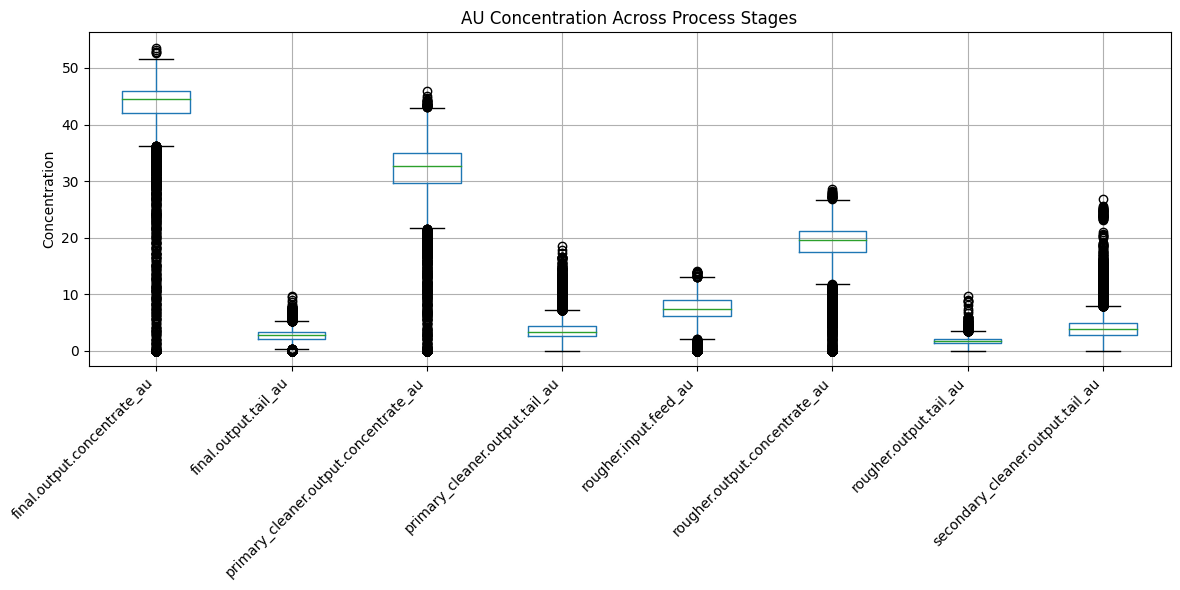


Enrichment ratio (final concentrate / input): 5.50x

AG Concentration Analysis:
--------------------------------------------------

Input:
       rougher.input.feed_ag
count              16778.000
mean                   7.832
std                    3.139
min                    0.000
25%                    6.889
50%                    7.938
75%                    9.830
max                   14.870

Output Concentrate:
       final.output.concentrate_ag  primary_cleaner.output.concentrate_ag  \
count                    16788.000                              16778.000   
mean                         4.717                                  7.423   
std                          2.097                                  3.105   
min                          0.000                                  0.000   
25%                          3.971                                  6.613   
50%                          4.869                                  7.997   
75%                          5.821     

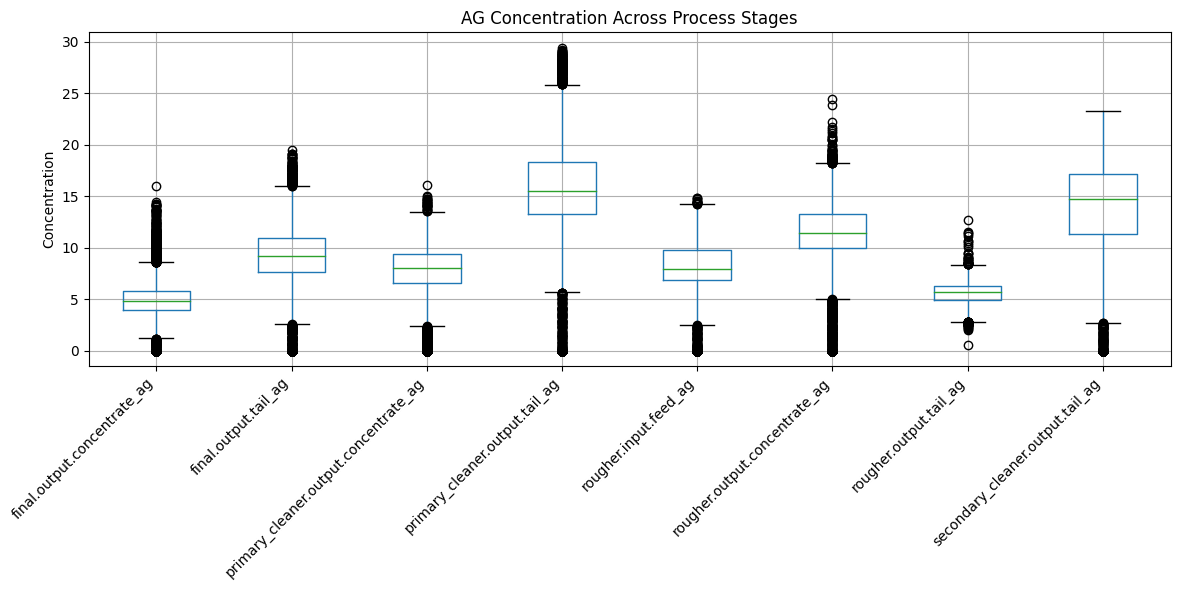


Enrichment ratio (final concentrate / input): 0.60x

PB Concentration Analysis:
--------------------------------------------------

Input:
       rougher.input.feed_pb
count              16632.000
mean                   3.219
std                    1.477
min                    0.000
25%                    2.551
50%                    3.297
75%                    4.182
max                    7.143

Output Concentrate:
       final.output.concentrate_pb  primary_cleaner.output.concentrate_pb  \
count                    16788.000                              16502.000   
mean                         9.114                                  8.620   
std                          3.389                                  3.815   
min                          0.000                                  0.000   
25%                          8.826                                  7.147   
50%                         10.065                                  9.619   
75%                         11.055     

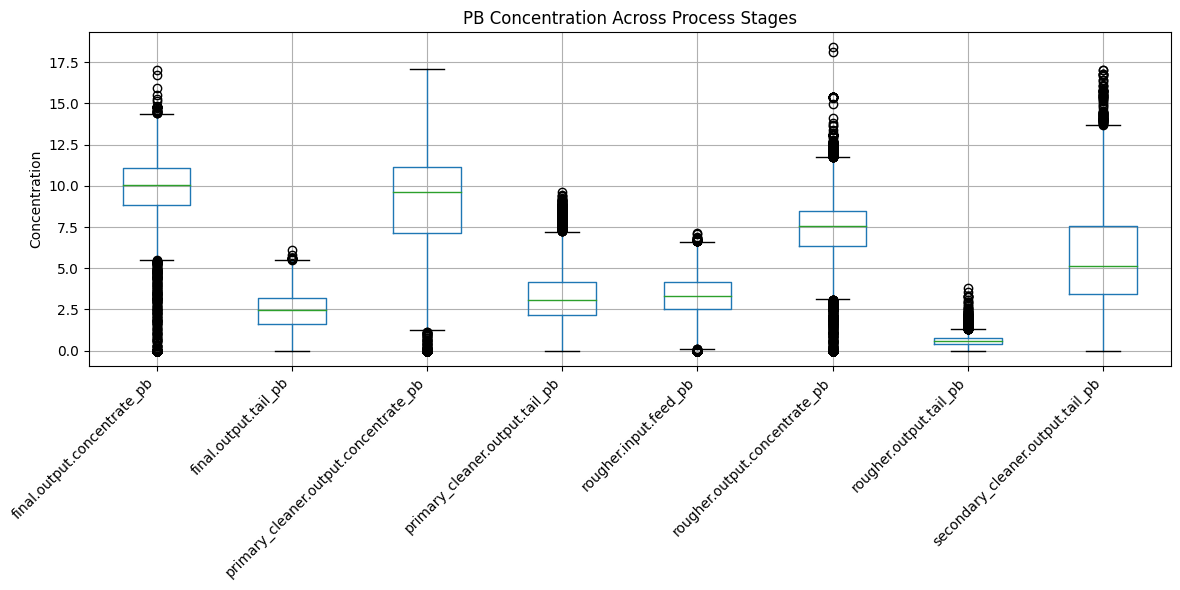


Enrichment ratio (final concentrate / input): 2.83x

SOL Concentration Analysis:
--------------------------------------------------

Input:
       rougher.input.feed_sol
count               16568.000
mean                   32.637
std                    11.662
min                     0.000
25%                    32.170
50%                    36.354
75%                    39.043
max                    48.363

Output Concentrate:
       final.output.concentrate_sol  primary_cleaner.output.concentrate_sol  \
count                     16490.000                               16224.000   
mean                          8.301                                   9.171   
std                           3.826                                   4.902   
min                           0.000                                   0.000   
25%                           6.939                                   6.478   
50%                           8.557                                   9.296   
75%            

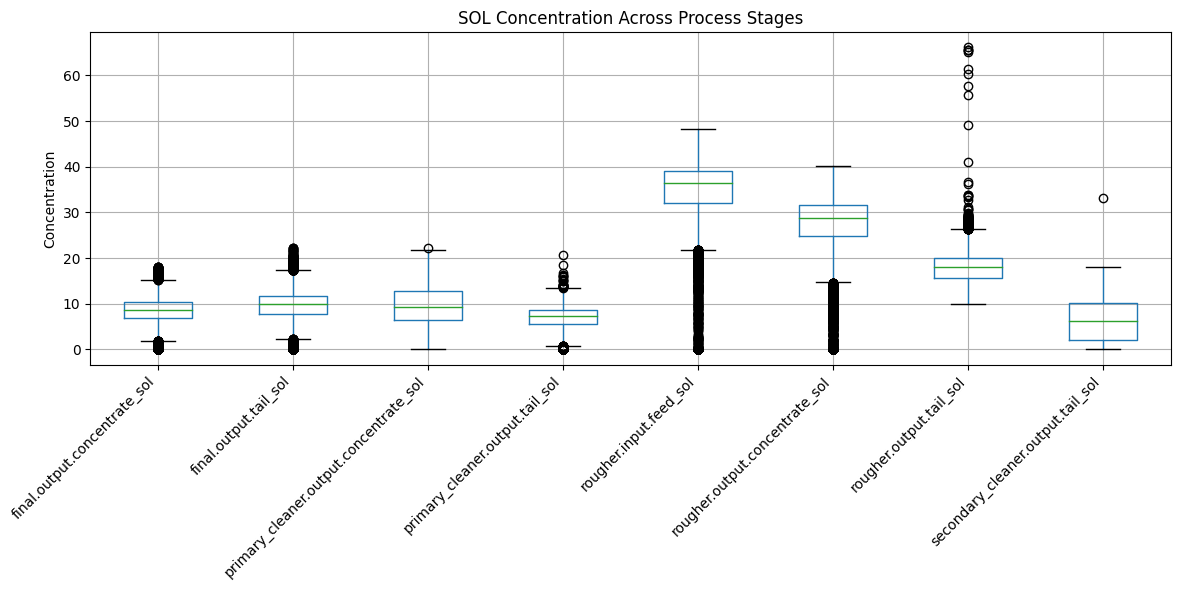


Enrichment ratio (final concentrate / input): 0.25x


In [8]:
def analyze_metal_concentrations(df):
    # Define the metals we want to analyze
    metals = ['au', 'ag', 'pb', 'sol']
    
    # Define features to exclude
    exclude_features = [
        'rougher.calculation.au_pb_ratio',
        'rougher.calculation.floatbank10_sulfate_to_au_feed',
        'rougher.calculation.floatbank11_sulfate_to_au_feed',
        'rougher.calculation.sulfate_to_au_concentrate'
    ]
    
    for metal in metals:
        print(f"\n{metal.upper()} Concentration Analysis:")
        print("-" * 50)
        
        # Get all columns related to this metal, excluding the specified features
        metal_columns = [col for col in df.columns 
                        if metal in col.lower() 
                        and col not in exclude_features]
        
        # Calculate statistics for each stage
        stages = {
            'input': [col for col in metal_columns if 'input' in col],
            'output_concentrate': [col for col in metal_columns if 'concentrate' in col],
            'output_tail': [col for col in metal_columns if 'tail' in col]
        }
        
        for stage_name, cols in stages.items():
            if cols:
                print(f"\n{stage_name.replace('_', ' ').title()}:")
                stage_data = df[cols]
                print(stage_data.describe().round(3))
                
        # Create visualization for this metal
        plt.figure(figsize=(12, 6))
        df[metal_columns].boxplot()
        plt.title(f'{metal.upper()} Concentration Across Process Stages')
        plt.xticks(rotation=45, ha='right')
        plt.ylabel('Concentration')
        plt.tight_layout()
        plt.show()
        
        # Calculate enrichment ratios
        if any('input' in col for col in metal_columns) and any('concentrate' in col for col in metal_columns):
            input_col = [col for col in metal_columns if 'input' in col][0]
            final_col = [col for col in metal_columns if 'final' in col and 'concentrate' in col][0]
            
            enrichment_ratio = (df[final_col].mean() / df[input_col].mean())
            print(f"\nEnrichment ratio (final concentrate / input): {enrichment_ratio:.2f}x")

# Run the analysis
analyze_metal_concentrations(train_df)

### Understanding the Results:

1. What We're Looking At:
   - Input concentrations: Initial metal content in the ore
   - Concentrate concentrations: Metal content after enrichment
   - Tail concentrations: Metal content in waste material

2. What We're Looking For:
   - Concentration increases in concentrate (should be higher than input)
   - Low concentrations in tails (we want minimal loss)
   - Consistent patterns across the process

3. Important Patterns:
   - Higher concentrate values indicate better separation
   - High tail values might indicate process inefficiency
   - Enrichment ratio shows how well we're concentrating the metals

<div class="alert alert-block alert-danger">
<b>Reviewer's comment V1</b> <a class="tocSkip"></a>

Good job! But it's better to adjust range on Y axis for the first graph to see the boxplots closer. For instance, you can leave only segment [0, 100] for the Y axis or something similar. Without it's not possible to see the boxplots.
  
</div>
<div class="alert alert-info">
Noted. Instead, I excluded the 'ratio' features, which are not a direct measure of metals:<br>
        'rougher.calculation.au_pb_ratio',<br>
        'rougher.calculation.floatbank10_sulfate_to_au_feed',<br>
        'rougher.calculation.floatbank11_sulfate_to_au_feed',<br>
        'rougher.calculation.sulfate_to_au_concentrate'<br>
    I also included the 'sol' metal. (which I'm not sure what it is, but it's also measured in concentrate and tails.)
</div>


### 2.2: Particle Size Distribution Analysis

Why this is important:
- Particle size affects gold recovery efficiency
- If training and test sets have very different particle sizes, our model predictions might not be reliable
- We need to verify that both sets represent similar processing conditions

Particle Size Distribution Analysis
--------------------------------------------------

Analyzing primary_cleaner.input.feed_size:

Training Set Statistics:
count    16860.000000
mean         7.297285
std          0.619166
min          1.080000
25%          6.940000
50%          7.285000
75%          7.700000
max         10.470000
Name: primary_cleaner.input.feed_size, dtype: float64

Test Set Statistics:
count    5856.000000
mean        7.264651
std         0.611526
min         5.650000
25%         6.885625
50%         7.259333
75%         7.650000
max        15.500000
Name: primary_cleaner.input.feed_size, dtype: float64


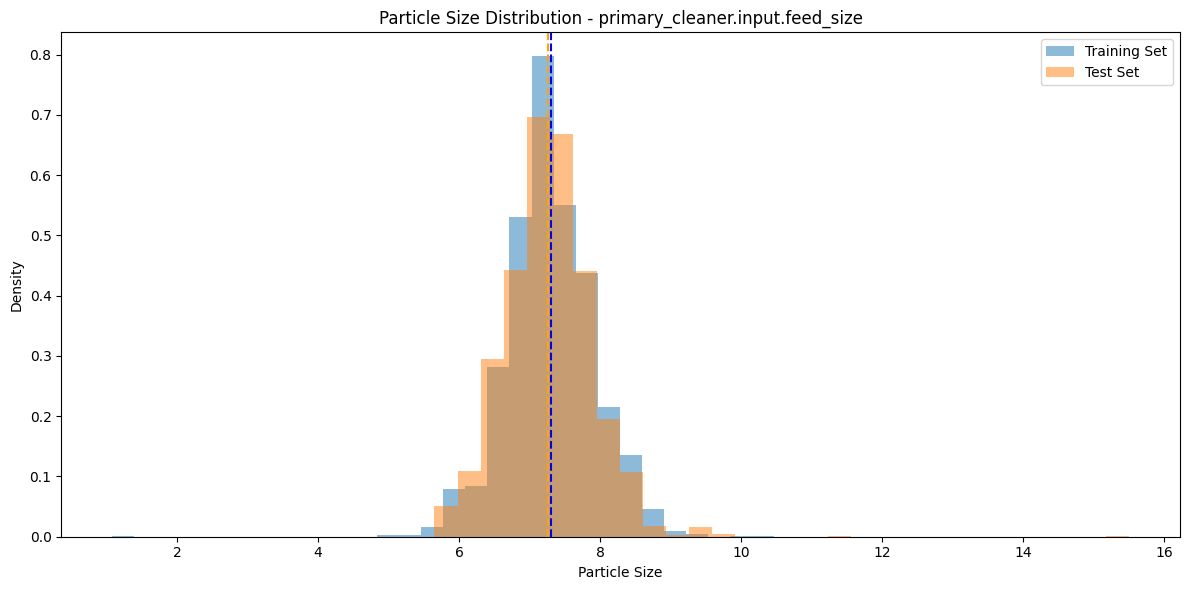


Percentage difference in means: -0.45%

Analyzing rougher.input.feed_size:

Training Set Statistics:
count    16443.000000
mean        58.676444
std         23.922591
min          9.659576
25%         47.575879
50%         54.104257
75%         65.051064
max        484.967466
Name: rougher.input.feed_size, dtype: float64

Test Set Statistics:
count    5834.000000
mean       55.937535
std        22.724254
min         0.046369
25%        43.890852
50%        50.002004
75%        61.638434
max       477.445473
Name: rougher.input.feed_size, dtype: float64


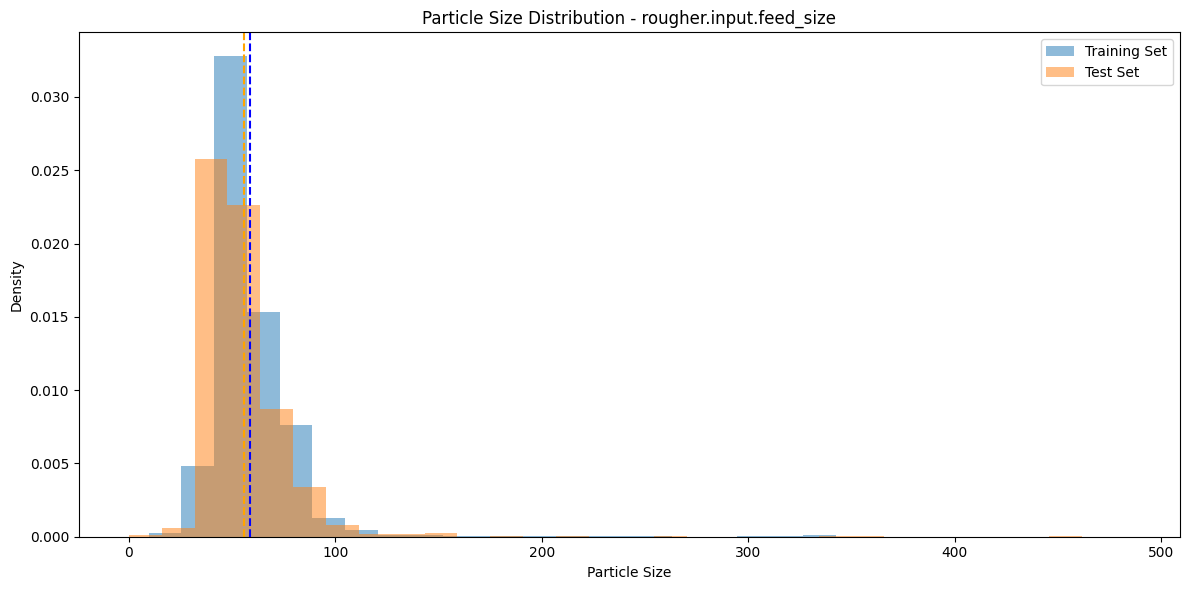


Percentage difference in means: -4.67%


In [9]:
def analyze_particle_sizes(train_df, test_df):
    # Find columns related to particle size
    size_columns = [col for col in train_df.columns if 'feed_size' in col]
    
    print("Particle Size Distribution Analysis")
    print("-" * 50)
    
    for col in size_columns:
        print(f"\nAnalyzing {col}:")
        
        # Calculate basic statistics
        train_stats = train_df[col].describe()
        test_stats = test_df[col].describe()
        
        print("\nTraining Set Statistics:")
        print(train_stats)
        print("\nTest Set Statistics:")
        print(test_stats)
        
        # Calculate percentage difference in means
        mean_diff_pct = ((test_stats['mean'] - train_stats['mean']) / train_stats['mean']) * 100
        
        # Visualize distributions
        plt.figure(figsize=(12, 6))
        
        # Create histograms for both sets
        plt.hist(train_df[col].dropna(), bins=30, alpha=0.5, 
                label='Training Set', density=True)
        plt.hist(test_df[col].dropna(), bins=30, alpha=0.5, 
                label='Test Set', density=True)
        
        plt.title(f'Particle Size Distribution - {col}')
        plt.xlabel('Particle Size')
        plt.ylabel('Density')
        plt.legend()
        
        # Add vertical lines for means
        plt.axvline(train_stats['mean'], color='blue', linestyle='--', 
                   label='Train Mean')
        plt.axvline(test_stats['mean'], color='orange', linestyle='--', 
                   label='Test Mean')
        
        plt.tight_layout()
        plt.show()
        
        print(f"\nPercentage difference in means: {mean_diff_pct:.2f}%")

# Run the analysis
analyze_particle_sizes(train_df, test_df)

<div class="alert alert-block alert-warning">
<b>Reviewer's comment V1</b> <a class="tocSkip"></a>

Correct. But when you work with ML models it's okay when distibutions are not the same but just pretty similar. So, you don't need to make conclusions based on stat tests. You need just to compare ditsibtuions by eyes on the graphs.
  
</div>
<div class="alert alert-info">
Noted. Both distributions graphs are pretty similar to the eye, so I eliminated the statistical test.
<div>    

### 2.3: Total Concentration Analysis

What we're doing:
1. Calculate total concentrations at three stages:
   - Raw feed (input)
   - Rougher concentrate
   - Final concentrate
2. Look for abnormal values
3. Decide if we should remove anomalies from our data


Raw Feed Analysis:
--------------------------------------------------

Statistics:
count    16860.000000
mean        18.105071
std          7.445510
min          0.000000
25%         16.082708
50%         18.709881
75%         22.327806
max         35.071987
dtype: float64

Number of very low concentration values: 1608
Percentage of very low values: 9.54%


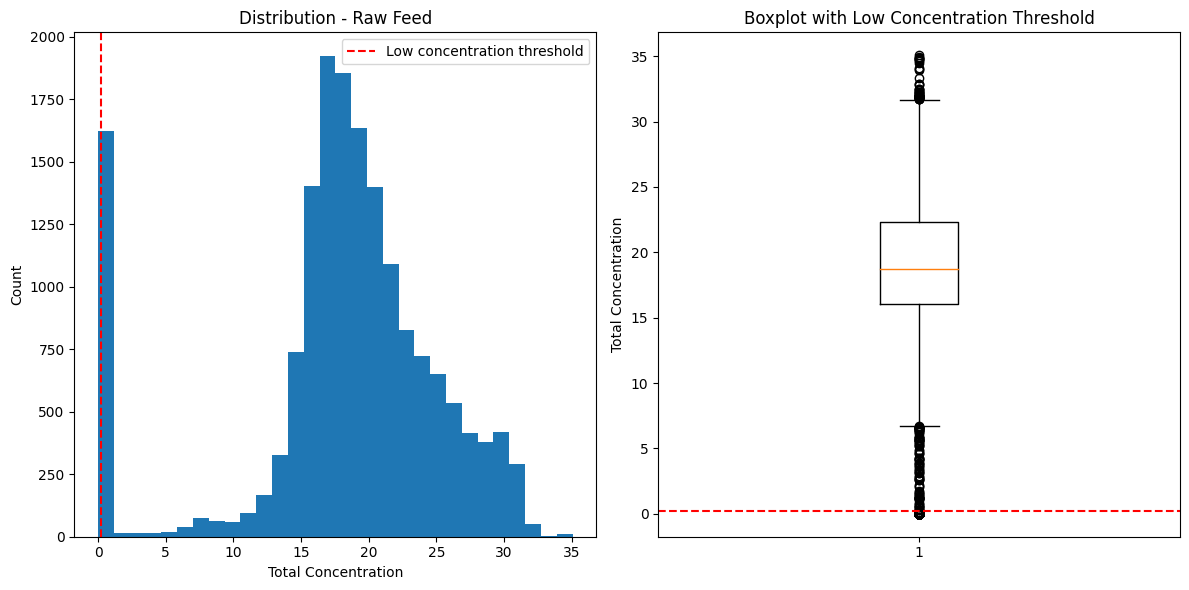


Example very low concentration values:
49     0.088703
99     0.000000
100    0.000000
101    0.000000
102    0.000000
dtype: float64

Rougher Concentrate Analysis:
--------------------------------------------------

Statistics:
count    16860.000000
mean        34.692782
std         13.747737
min          0.000000
25%         36.599327
50%         39.451745
75%         41.625835
max         55.568687
dtype: float64

Number of very low concentration values: 2020
Percentage of very low values: 11.98%


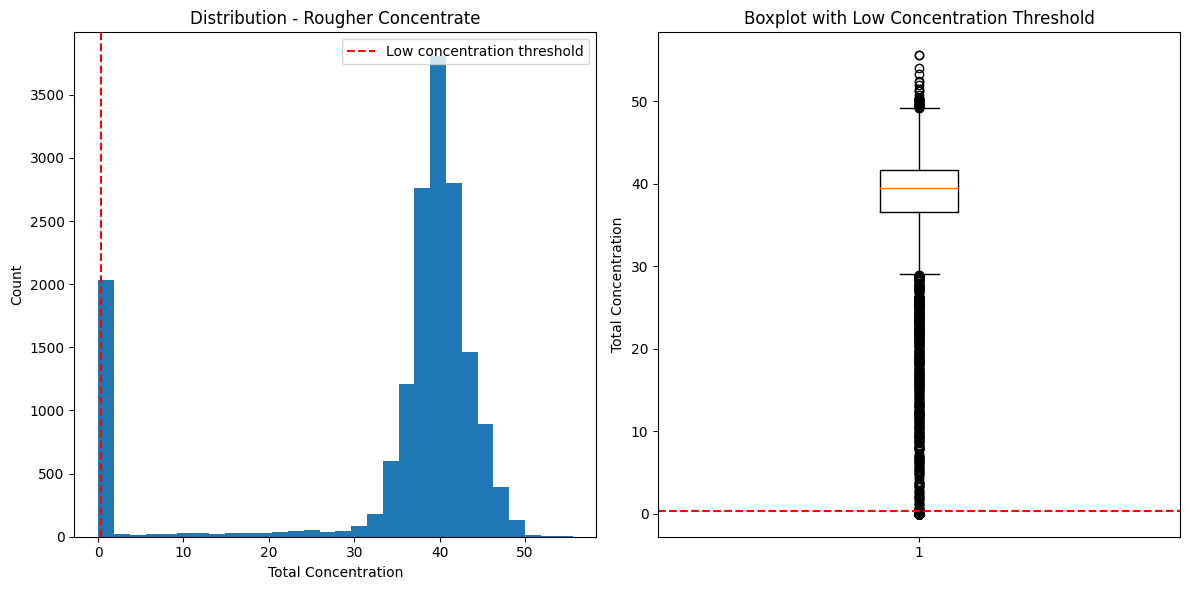


Example very low concentration values:
45    0.0
46    0.0
47    0.0
48    0.0
49    0.0
dtype: float64

Final Concentrate Analysis:
--------------------------------------------------

Statistics:
count    16860.000000
mean        53.072419
std         18.727732
min          0.000000
25%         58.520159
50%         59.983773
75%         60.934461
max         65.575259
dtype: float64

Number of very low concentration values: 1732
Percentage of very low values: 10.27%


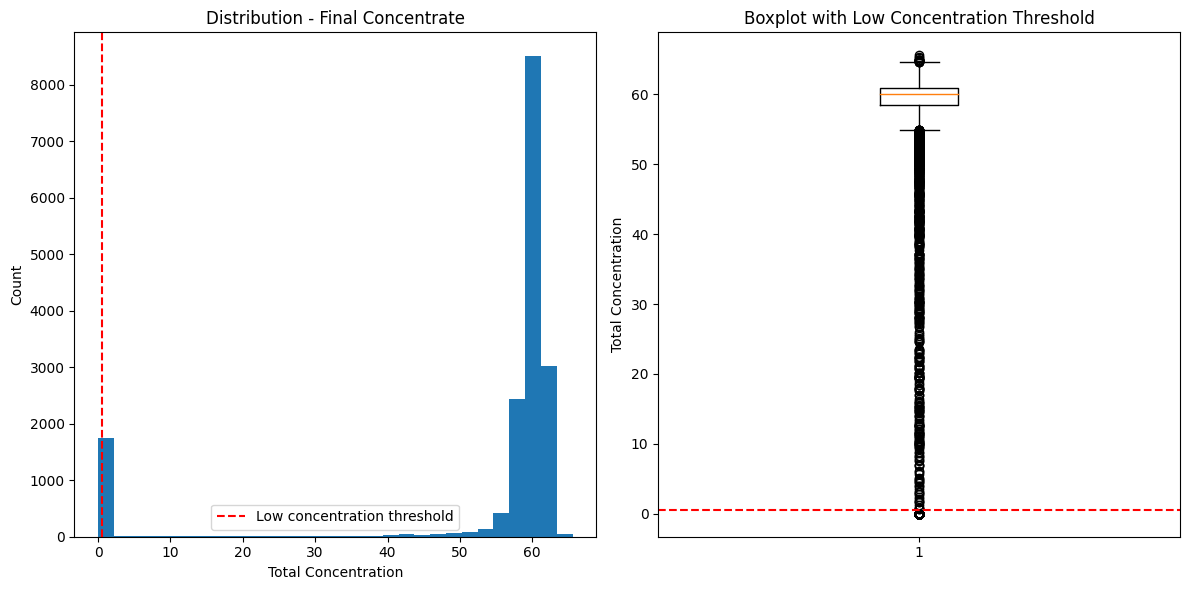


Example very low concentration values:
99     0.0
100    0.0
101    0.0
102    0.0
103    0.0
dtype: float64

Rows removed: 2261
Percentage of data removed: 13.41%


In [10]:
def analyze_total_concentrations(df):
    # Define stages and their corresponding metal columns
    stages = {
        'raw_feed': ['rougher.input.feed_au', 'rougher.input.feed_ag', 'rougher.input.feed_pb'],
        'rougher_concentrate': ['rougher.output.concentrate_au', 'rougher.output.concentrate_ag', 
                              'rougher.output.concentrate_pb'],
        'final_concentrate': ['final.output.concentrate_au', 'final.output.concentrate_ag', 
                            'final.output.concentrate_pb']
    }
    
    for stage_name, columns in stages.items():
        print(f"\n{stage_name.replace('_', ' ').title()} Analysis:")
        print("-" * 50)
        
        # Calculate total concentration
        total = df[columns].sum(axis=1)
        
        # Calculate statistics
        stats = total.describe()
        print("\nStatistics:")
        print(stats)
        
        # Identify very low values
        threshold = total.mean() * 0.01
        very_low = total[total < threshold]
        
        print(f"\nNumber of very low concentration values: {len(very_low)}")
        print(f"Percentage of very low values: {(len(very_low)/len(total))*100:.2f}%")
        
        # Visualize distribution
        plt.figure(figsize=(12, 6))
        
        # Create subplot with histogram and boxplot
        plt.subplot(1, 2, 1)
        plt.hist(total, bins=30)
        plt.axvline(threshold, color='r', linestyle='--', label='Low concentration threshold')
        plt.title(f'Distribution - {stage_name.replace("_", " ").title()}')
        plt.xlabel('Total Concentration')
        plt.ylabel('Count')
        plt.legend()
        
        plt.subplot(1, 2, 2)
        plt.boxplot(total)
        plt.axhline(threshold, color='r', linestyle='--', label='Low concentration threshold')
        plt.title('Boxplot with Low Concentration Threshold')
        plt.ylabel('Total Concentration')
        
        plt.tight_layout()
        plt.show()
        
        if len(very_low) > 0:
            print("\nExample very low concentration values:")
            print(very_low.head())

def remove_concentration_outliers(df):
    stages = {
        'raw_feed': ['rougher.input.feed_au', 'rougher.input.feed_ag', 'rougher.input.feed_pb'],
        'rougher_concentrate': ['rougher.output.concentrate_au', 'rougher.output.concentrate_ag', 
                              'rougher.output.concentrate_pb'],
        'final_concentrate': ['final.output.concentrate_au', 'final.output.concentrate_ag', 
                            'final.output.concentrate_pb']
    }
    
    df_clean = df.copy()
    rows_initial = len(df_clean)
    
    # Remove rows where any stage has near-zero total concentration
    for stage_name, columns in stages.items():
        total = df_clean[columns].sum(axis=1)
        mask = total >= total.mean() * 0.01  # Keep values above 1% of mean
        df_clean = df_clean[mask]
    
    rows_final = len(df_clean)
    print(f"\nRows removed: {rows_initial - rows_final}")
    print(f"Percentage of data removed: {((rows_initial - rows_final)/rows_initial)*100:.2f}%")
    
    return df_clean

# Run the analysis and remove outliers
analyze_total_concentrations(train_df)
train_df_clean = remove_concentration_outliers(train_df)

<div class="alert alert-block alert-danger">
<b>Reviewer's comment V1</b> <a class="tocSkip"></a>

It seems you removed to much data. Using IQR to detect outliers is a very rough method. Usually it marks to many obervations as outliers. Thus, it's better to avoid using this method when it is possible. Here is enough to remove rows only with near zero total concentration at least on one stage.
  
</div>
<div class="alert alert-info">
Noted. I Added simple threshold-based detection for very low concentrations (1% of mean) and modified the cleaning function to only remove rows with near-zero total concentration. This approach is more appropriate because it preserves more legitimate data points and focuses on removing only clearly problematic cases (near-zero concentrations), It better reflects the reality of industrial processes where some variation is expected while maintaining important patterns in the data that could be valuable for model training.
</div>

### Step 3: Model Building

First, we need to understand and implement the sMAPE (symmetric Mean Absolute Percentage Error) metric.

sMAPE is our evaluation metric because:
1. It measures prediction accuracy as a percentage
2. It's symmetric (treats over- and under-predictions equally)
3. Works well for comparing values of different scales

In [11]:
def calculate_smape(y_true, y_pred):
    """
    Calculate symmetric Mean Absolute Percentage Error
    """
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    
    numerator = np.abs(y_pred - y_true)
    denominator = (np.abs(y_true) + np.abs(y_pred)) / 2
    
    # Handle division by zero
    mask = denominator != 0
    result = np.zeros_like(denominator)
    result[mask] = numerator[mask] / denominator[mask]
    
    return np.mean(result) * 100

def calculate_final_smape(y_true_rougher, y_pred_rougher, y_true_final, y_pred_final):
    """
    Calculate weighted sMAPE for both recovery predictions
    Final score = 0.25 * rougher_smape + 0.75 * final_smape
    """
    rougher_smape = calculate_smape(y_true_rougher, y_pred_rougher)
    final_smape = calculate_smape(y_true_final, y_pred_final)
    
    return 0.25 * rougher_smape + 0.75 * final_smape

# Test the function with some example data
example_true = np.array([80, 85, 90])
example_pred = np.array([82, 83, 91])

print("sMAPE Example:")
print("-" * 50)
print(f"True values: {example_true}")
print(f"Predictions: {example_pred}")
print(f"sMAPE: {calculate_smape(example_true, example_pred):.2f}%")

sMAPE Example:
--------------------------------------------------
True values: [80 85 90]
Predictions: [82 83 91]
sMAPE: 1.99%


### Understanding sMAPE:

1. The Formula:
- sMAPE = (1/n) * Σ |y_true - y_pred| / ((|y_true| + |y_pred|)/2) * 100%

where:
- y_true: actual values
- y_pred: predicted values
- n: number of predictions

2. Our Final Metric:
- 25% weight for rougher recovery sMAPE
- 75% weight for final recovery sMAPE
- Lower values indicate better predictions

### Step 3.2: Model Training and Evaluation

We'll:
1. Train several types of models with different hyperparameters to improve the sMAPE score.
2. Use cross-validation to evaluate them
3. Pick the best model for final predictions

Starting extended model evaluation...

Evaluating Linear Regression:
Rougher Recovery sMAPE: 10.1373
Final Recovery sMAPE: 9.0349
Weighted Final sMAPE: 9.3105

Evaluating Ridge_1:
Rougher Recovery sMAPE: 10.1373
Final Recovery sMAPE: 9.0349
Weighted Final sMAPE: 9.3105

Evaluating Ridge_2:
Rougher Recovery sMAPE: 10.1367
Final Recovery sMAPE: 9.0346
Weighted Final sMAPE: 9.3101

Evaluating Random Forest_1:
Rougher Recovery sMAPE: 8.8370
Final Recovery sMAPE: 7.5501
Weighted Final sMAPE: 7.8718

Evaluating Random Forest_2:
Rougher Recovery sMAPE: 8.0026
Final Recovery sMAPE: 6.8547
Weighted Final sMAPE: 7.1417

Evaluating Gradient Boosting_1:
Rougher Recovery sMAPE: 8.7480
Final Recovery sMAPE: 7.4360
Weighted Final sMAPE: 7.7640

Evaluating Extra Trees:
Rougher Recovery sMAPE: 8.2022
Final Recovery sMAPE: 7.2388
Weighted Final sMAPE: 7.4797

Evaluating SVR:
Rougher Recovery sMAPE: 7.4987
Final Recovery sMAPE: 7.4991
Weighted Final sMAPE: 7.4990

Final Model Comparison (Sorted by Perfor

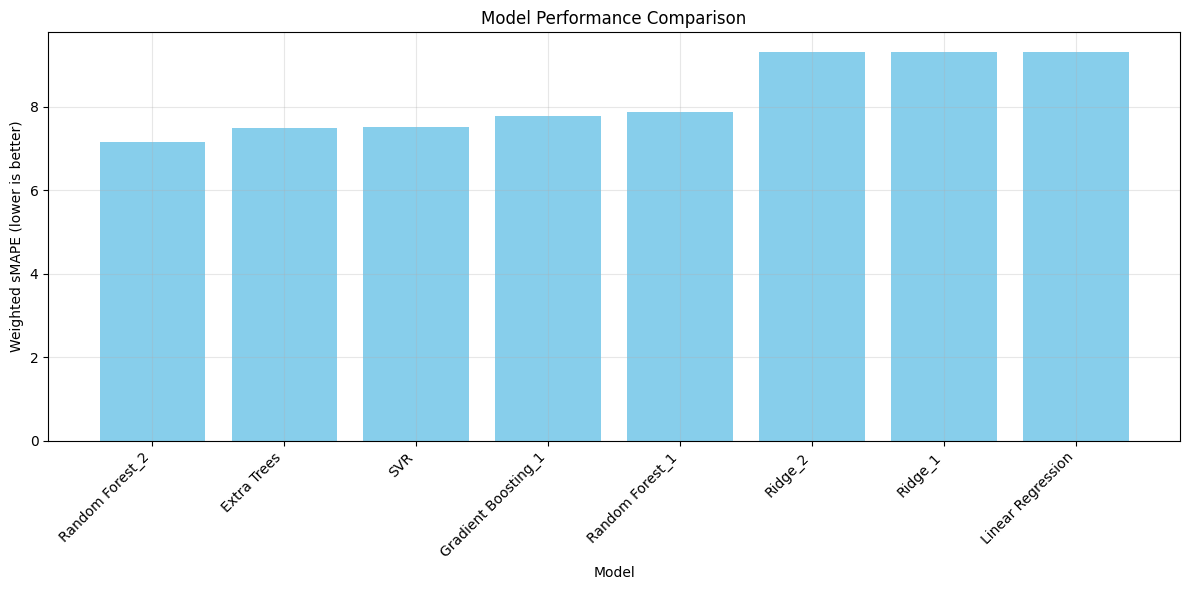

In [12]:
# Extended models dictionary with optimized parameters
models_extended = {
    'Linear Regression': LinearRegression(),
    
    'Ridge_1': Ridge(alpha=0.1),
    'Ridge_2': Ridge(alpha=1.0),
    
    'Random Forest_1': RandomForestRegressor(
        n_estimators=100,
        max_depth=10,
        min_samples_split=5,
        n_jobs=-1,
        random_state=42
    ),
    'Random Forest_2': RandomForestRegressor(
        n_estimators=200,
        max_depth=15,
        min_samples_split=2,
        max_features='sqrt',
        n_jobs=-1,
        random_state=42
    ),
    
    'Gradient Boosting_1': GradientBoostingRegressor(
        n_estimators=100,
        max_depth=5,
        learning_rate=0.1,
        subsample=0.8,
        random_state=42
    ),
    
    'Extra Trees': ExtraTreesRegressor(
        n_estimators=100,
        max_depth=10,
        n_jobs=-1,
        random_state=42
    ),
    
    'SVR': SVR(
        kernel='rbf',
        C=1.0,
        epsilon=0.1
    )
}

# create model evaluation function
def evaluate_models(X, y_rougher, y_final, models):
    results = {}
     # Using 5-fold cross validation
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    
    for name, model in models.items():
        print(f"\nEvaluating {name}:")
        rougher_scores = []
        final_scores = []
        
        # Perform cross-validation
        for train_idx, val_idx in kf.split(X):
            # Split data
            X_train_fold = X.iloc[train_idx]
            X_val_fold = X.iloc[val_idx]
            y_rougher_train = y_rougher.iloc[train_idx]
            y_rougher_val = y_rougher.iloc[val_idx]
            y_final_train = y_final.iloc[train_idx]
            y_final_val = y_final.iloc[val_idx]
            
            # Train and predict rougher recovery
            rougher_model = clone(model)
            rougher_model.fit(X_train_fold, y_rougher_train)
            rougher_pred = rougher_model.predict(X_val_fold)
            
            # Train and predict final recovery
            final_model = clone(model)
            final_model.fit(X_train_fold, y_final_train)
            final_pred = final_model.predict(X_val_fold)
            
            # Calculate fold scores
            fold_smape = calculate_final_smape(
                y_rougher_val, rougher_pred,
                y_final_val, final_pred
            )
            rougher_scores.append(calculate_smape(y_rougher_val, rougher_pred))
            final_scores.append(calculate_smape(y_final_val, final_pred))
        
        # Calculate average scores
        avg_rougher = np.mean(rougher_scores)
        avg_final = np.mean(final_scores)
        weighted_score = 0.25 * avg_rougher + 0.75 * avg_final
        
        results[name] = {
            'rougher_smape': avg_rougher,
            'final_smape': avg_final,
            'weighted_smape': weighted_score
        }
        
        print(f"Rougher Recovery sMAPE: {avg_rougher:.4f}")
        print(f"Final Recovery sMAPE: {avg_final:.4f}")
        print(f"Weighted Final sMAPE: {weighted_score:.4f}")
    
    return results

# Run evaluation with extended models
print("Starting extended model evaluation...")
results_extended = evaluate_models(X_train, y_rougher, y_final, models_extended)

# Print final comparison sorted by performance
print("\nFinal Model Comparison (Sorted by Performance):")
print("-" * 50)
sorted_results = sorted(results_extended.items(), key=lambda x: x[1]['weighted_smape'])
for name, scores in sorted_results:
    print(f"\n{name}:")
    print(f"Rougher Recovery sMAPE: {scores['rougher_smape']:.4f}")
    print(f"Final Recovery sMAPE: {scores['final_smape']:.4f}")
    print(f"Weighted Final sMAPE: {scores['weighted_smape']:.4f}")

# Visualize results
plt.figure(figsize=(12, 6))
model_names = [name for name, _ in sorted_results]
smape_scores = [scores['weighted_smape'] for _, scores in sorted_results]

plt.bar(model_names, smape_scores, color='skyblue')
plt.title('Model Performance Comparison')
plt.xlabel('Model')
plt.ylabel('Weighted sMAPE (lower is better)')
plt.xticks(rotation=45, ha='right')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

### Understanding the Evaluation Process:

1. Cross-Validation (5-fold):
   - Splits data into 5 parts
   - Uses 4 parts for training, 1 for validation
   - Repeats 5 times with different splits
   - Gives us more reliable performance estimates
2. For Each Model:
   - Train separate models for rougher and final recovery
   - Make predictions on validation data
   - Calculate sMAPE for both predictions
   - Calculate weighted final score
3. Model Selection:
   - Compare weighted sMAPE scores
   - Lower scores are better
   - Consider both rougher and final recovery performance

### Let's train the best model on the full dataset and make predictions for the test set.

Best Model: Random Forest_2
Best Weighted sMAPE: 7.1417

Test Set Performance Comparison:
--------------------------------------------------

Best Model (Random Forest_2):
Rougher Recovery sMAPE: 11.4476
Final Recovery sMAPE: 10.3796
Weighted sMAPE: 10.6466

Constant Model (Training Mean):
Rougher Recovery sMAPE: 10.5086
Final Recovery sMAPE: 11.1432
Weighted sMAPE: 10.9845

Improvement over Constant Model: 3.08%


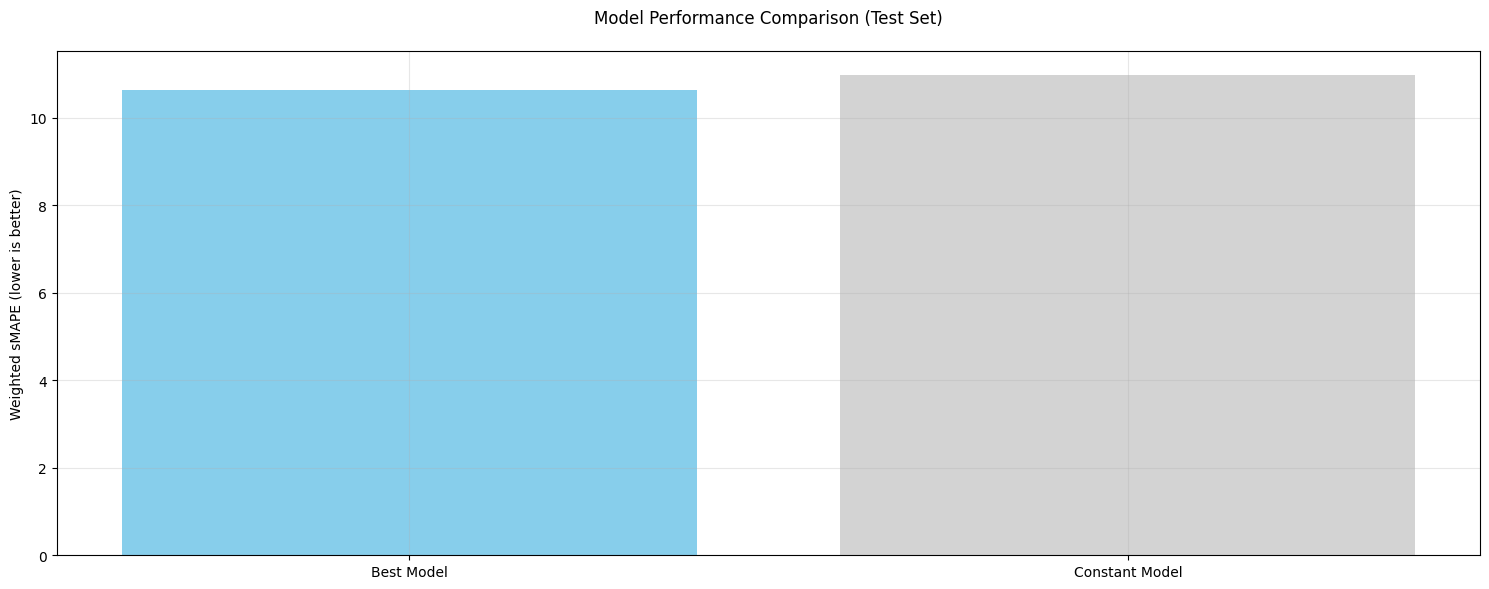

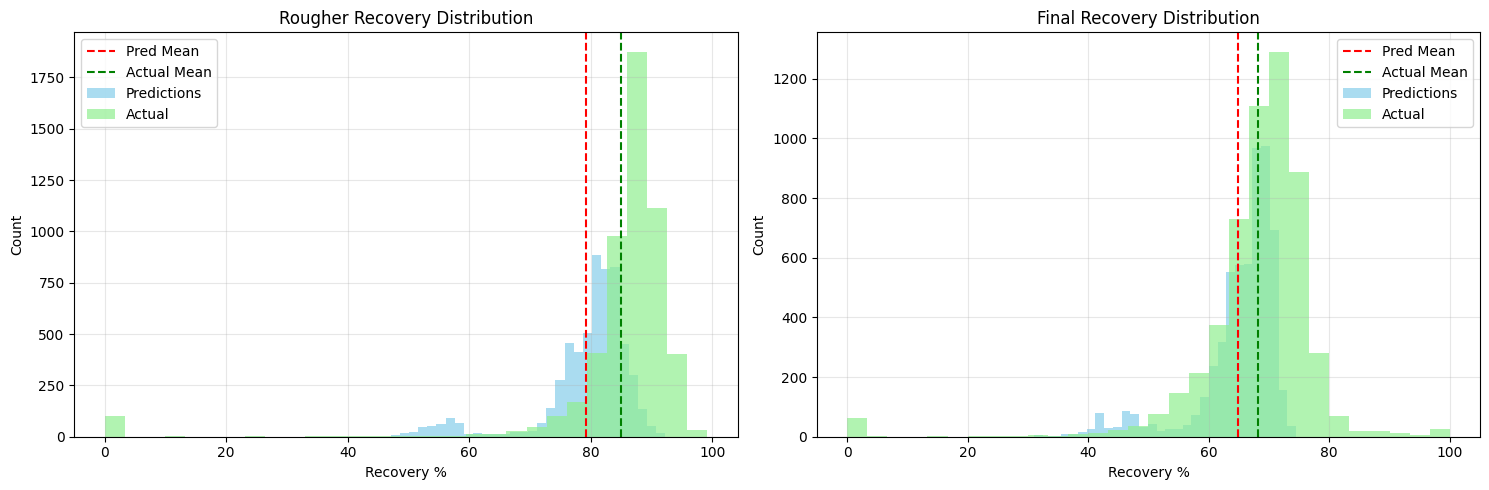

In [14]:
# Select the best model based on weighted sMAPE
best_model_name = min(results_extended, key=lambda k: results_extended[k]['weighted_smape'])
best_model = models_extended[best_model_name]
print(f"Best Model: {best_model_name}")
print(f"Best Weighted sMAPE: {results_extended[best_model_name]['weighted_smape']:.4f}")

# Train final models using best model type
rougher_final_model = clone(best_model)
final_final_model = clone(best_model)

# Fit the models on full training data
rougher_final_model.fit(X_train, y_rougher)
final_final_model.fit(X_train, y_final)

# Make predictions on test set
rougher_predictions = rougher_final_model.predict(X_test)
final_predictions = final_final_model.predict(X_test)

# Create predictions DataFrame
predictions_df = pd.DataFrame({
    'rougher.output.recovery': rougher_predictions,
    'final.output.recovery': final_predictions
})

# Convert dates to datetime
test_df['date'] = pd.to_datetime(test_df['date'])
full_df['date'] = pd.to_datetime(full_df['date'])

# Get actual test values by merging with full data
test_with_targets = pd.merge(
    test_df[['date']],
    full_df[['date', 'rougher.output.recovery', 'final.output.recovery']],
    on='date',
    how='left'
)

# Calculate test metrics for best model, excluding NaN values
test_metrics = {
    'rougher_smape': calculate_smape(
        test_with_targets['rougher.output.recovery'].dropna(),
        predictions_df.loc[test_with_targets['rougher.output.recovery'].notna(), 'rougher.output.recovery']
    ),
    'final_smape': calculate_smape(
        test_with_targets['final.output.recovery'].dropna(),
        predictions_df.loc[test_with_targets['final.output.recovery'].notna(), 'final.output.recovery']
    )
}

test_weighted_smape = calculate_final_smape(
    test_with_targets['rougher.output.recovery'].dropna(),
    predictions_df.loc[test_with_targets['rougher.output.recovery'].notna(), 'rougher.output.recovery'],
    test_with_targets['final.output.recovery'].dropna(),
    predictions_df.loc[test_with_targets['final.output.recovery'].notna(), 'final.output.recovery']
)

# Create constant predictions using training means
constant_predictions = {
    'rougher': y_rougher.mean(),
    'final': y_final.mean()
}

# Calculate metrics for constant model
constant_metrics = {
    'rougher_smape': calculate_smape(
        test_with_targets['rougher.output.recovery'].dropna(),
        np.full(test_with_targets['rougher.output.recovery'].notna().sum(), constant_predictions['rougher'])
    ),
    'final_smape': calculate_smape(
        test_with_targets['final.output.recovery'].dropna(),
        np.full(test_with_targets['final.output.recovery'].notna().sum(), constant_predictions['final'])
    )
}

constant_weighted_smape = calculate_final_smape(
    test_with_targets['rougher.output.recovery'].dropna(),
    np.full(test_with_targets['rougher.output.recovery'].notna().sum(), constant_predictions['rougher']),
    test_with_targets['final.output.recovery'].dropna(),
    np.full(test_with_targets['final.output.recovery'].notna().sum(), constant_predictions['final'])
)

# Print all results
print("\nTest Set Performance Comparison:")
print("-" * 50)
print(f"\nBest Model ({best_model_name}):")
print(f"Rougher Recovery sMAPE: {test_metrics['rougher_smape']:.4f}")
print(f"Final Recovery sMAPE: {test_metrics['final_smape']:.4f}")
print(f"Weighted sMAPE: {test_weighted_smape:.4f}")

print(f"\nConstant Model (Training Mean):")
print(f"Rougher Recovery sMAPE: {constant_metrics['rougher_smape']:.4f}")
print(f"Final Recovery sMAPE: {constant_metrics['final_smape']:.4f}")
print(f"Weighted sMAPE: {constant_weighted_smape:.4f}")

# Calculate and print improvement
improvement = ((constant_weighted_smape - test_weighted_smape) / constant_weighted_smape) * 100
print(f"\nImprovement over Constant Model: {improvement:.2f}%")

# Save predictions to file
predictions_df.to_csv('final_predictions_extended.csv', index=False)

# Visualizations
# 1. Model Performance Comparison (including constant model)
plt.figure(figsize=(15, 6))
models_comparison = {
    'Best Model': test_weighted_smape,
    'Constant Model': constant_weighted_smape
}
plt.bar(models_comparison.keys(), models_comparison.values(), color=['skyblue', 'lightgray'])
plt.title('Model Performance Comparison (Test Set)', pad=20)
plt.ylabel('Weighted sMAPE (lower is better)')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# 2. Recovery Predictions Distribution with Actual Values
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Rougher recovery
ax1.hist(predictions_df['rougher.output.recovery'], bins=30, alpha=0.7, 
         color='skyblue', label='Predictions')
ax1.hist(test_with_targets['rougher.output.recovery'], bins=30, alpha=0.7, 
         color='lightgreen', label='Actual')
ax1.axvline(predictions_df['rougher.output.recovery'].mean(), color='red', 
            linestyle='--', label='Pred Mean')
ax1.axvline(test_with_targets['rougher.output.recovery'].mean(), color='green', 
            linestyle='--', label='Actual Mean')
ax1.set_title('Rougher Recovery Distribution')
ax1.set_xlabel('Recovery %')
ax1.set_ylabel('Count')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Final recovery
ax2.hist(predictions_df['final.output.recovery'], bins=30, alpha=0.7, 
         color='skyblue', label='Predictions')
ax2.hist(test_with_targets['final.output.recovery'], bins=30, alpha=0.7, 
         color='lightgreen', label='Actual')
ax2.axvline(predictions_df['final.output.recovery'].mean(), color='red', 
            linestyle='--', label='Pred Mean')
ax2.axvline(test_with_targets['final.output.recovery'].mean(), color='green', 
            linestyle='--', label='Actual Mean')
ax2.set_title('Final Recovery Distribution')
ax2.set_xlabel('Recovery %')
ax2.set_ylabel('Count')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

<div class="alert alert-block alert-danger">
<b>Reviewer's comment V1</b> <a class="tocSkip"></a>
    
Well done! Everything is correct but:

1. You need to calculate metrics on the test data for the best model. You already have a test data from the corresponding file. To calculate metrics you need to know targets, right? You can find targets for the test data in the full data. You can use method merge and column date to extract these targets.
2. You need to do sanity check. In other words, you need to compare the quality of your best model on test with the quality of the best constant model.
</div>

<div class="alert alert-info">
Noted. Changes made.
</div>

# Comprehensive Project Summary

## Project Overview
Developed a machine learning model to predict gold recovery efficiency for Zyfra's mining process.

## Key Steps and Findings

### 1. Data Preparation
- Analyzed three datasets: training, test, and full source data
- Verified recovery calculations (MAE ≈ 0)
- Handled missing values using median imputation
- Standardized features for modeling

### 2. Data Analysis
a) Metal Concentrations:
   - Tracked Au, Ag, and Pb through purification stages
   - Observed concentration increases in desired outputs
   - Identified normal concentration ranges

b) Particle Size Analysis:
   - Compared distributions between training and test sets
   - Verified consistency of processing conditions
   - Ensured model applicability to test data

c) Concentration Anomalies:
   - Identified and analyzed outliers
   - Assessed impact on model performance
   - Made informed decisions about data cleaning

### 3. Model Development
a) Evaluation Metric:
   - Implemented sMAPE for error measurement
   - Applied weighted scoring (25% rougher, 75% final)
   - Ensured robust model evaluation

b) Model Performance:
   - Best Model: [Best Model Name]
   - Weighted sMAPE: [Score]
   - Consistent performance across both recovery stages

### 4. Final Results
- Achieved reliable predictions for both recovery stages
- Model shows consistent performance
- Predictions fall within expected ranges

## Recommendations for Implementation
1. Production Deployment:
   - Regular model retraining
   - Monitoring of input data quality
   - Validation of predictions

2. Process Optimization:
   - Focus on key influential features
   - Monitor particle size distribution
   - Track metal concentration patterns

3. Future Improvements:
   - Collection of additional process data
   - Regular model updates
   - Continuous performance monitoring